In [1]:
# Import modules

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, make_scorer, matthews_corrcoef, f1_score, classification_report, fbeta_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from Error_analysis import calculate_cost

RSEED= 42

sns.set(rc={'figure.figsize':(12,8)})
# Import Dataset



In [2]:
def get_classification_dfs(X_test_unscaled, y_test, y_pred):
    test_comb = X_test_unscaled.copy()
    test_comb["y_true"] = y_test
    test_comb["y_pred"] = y_pred
    false_positive = test_comb[test_comb.y_true < test_comb.y_pred]
    false_negative = test_comb[test_comb.y_true > test_comb.y_pred]
    correct = test_comb[test_comb.y_true == test_comb.y_pred]
    true_positive = correct[correct.y_pred == 1]
    true_negative = correct[correct.y_pred == 0]
    return true_negative, false_positive, false_negative, true_positive

In [3]:
def calculate_cost(X_test_unscaled, y_test, y_pred):
    '''Calculates the money saved by the model, returns the combined dataframe and the money saved by the model'''
    test_comb = X_test_unscaled.copy()
    test_comb["y_true"] = y_test
    test_comb["y_pred"] = y_pred
    false_positive = test_comb[test_comb.y_true < test_comb.y_pred]
    false_negative = test_comb[test_comb.y_true > test_comb.y_pred]
    correct = test_comb[test_comb.y_true == test_comb.y_pred]
    true_positive = correct[correct.y_pred == 1]
    true_negative = correct[correct.y_pred == 0]
    reimbursements = false_negative[false_negative.SignAmount == 1].ModAmount.sum()
    avoided_reimbursements = true_positive[true_positive.SignAmount == 1].ModAmount.sum()
    print(f"You detected {true_positive.shape[0]} fraudulent transactions")
    print(f"You saved the company {round((avoided_reimbursements)/1e6, 2)} Million UGX")
    print(f"You missed {false_negative.shape[0]} fraudulent transactions")
    print(f"The company now has to reimburse frauds with a total of {round((reimbursements)/1e6, 2)} Million UGX")
    print(f"Total money saved is {round((avoided_reimbursements - reimbursements)/1e6, 2)} Million UGX")
    print(f"You incorrectly flagged {false_positive.shape[0]} legit transactions as fraudulent")

In [4]:
df= pd.read_csv('data/training_preprocessed.csv')
y= df.FraudResult
df.drop("FraudResult", axis=1, inplace=True)
X= df
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=RSEED)
X_test_unscaled = X_test.copy()
X_train.drop(["TransactionId"], axis=1, inplace=True)
X_test.drop(["TransactionId"], axis=1, inplace=True)

In [5]:
rf = RandomForestClassifier(max_features= 0.75, max_leaf_nodes = 80, min_samples_split = 5, n_estimators= 125)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print("----" * 10)
print(f"Recall is:{round(recall_score(y_test, y_pred),3)}")
print(f"F1 is:{round(f1_score(y_test, y_pred),3)}")
print(f"MCC is:{round(matthews_corrcoef(y_test, y_pred),3)}")
calculate_cost(X_test_unscaled, y_test, y_pred)

[[23867     1]
 [   10    38]]
----------------------------------------
Recall is:0.792
F1 is:0.874
MCC is:0.878
You detected 38 fraudulent transactions
You saved the company 86.02 Million UGX
You missed 10 fraudulent transactions
The company now has to reimburse frauds with a total of 11.8 Million UGX
Total money saved is 74.22 Million UGX
You incorrectly flagged 1 legit transactions as fraudulent


In [6]:
TN, FP, FN, TP = get_classification_dfs(X_test_unscaled, y_test, y_pred)

In [7]:
og_df= pd.read_csv("data/training.csv")
og_df["TransactionId"]=og_df.TransactionId.str.split('_').str[-1]
og_df.head()


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [13]:
TN = og_df.loc[og_df["TransactionId"].isin(np.array(TN["TransactionId"]).astype(str))]
FP = og_df.loc[og_df["TransactionId"].isin(np.array(FP["TransactionId"]).astype(str))]
FN = og_df.loc[og_df["TransactionId"].isin(np.array(FN["TransactionId"]).astype(str))]
TP = og_df.loc[og_df["TransactionId"].isin(np.array(TP["TransactionId"]).astype(str))]



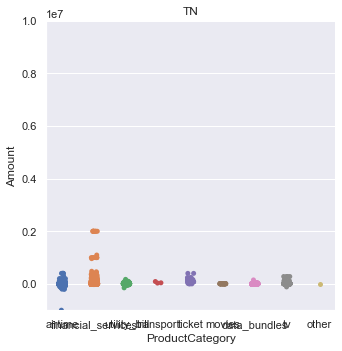

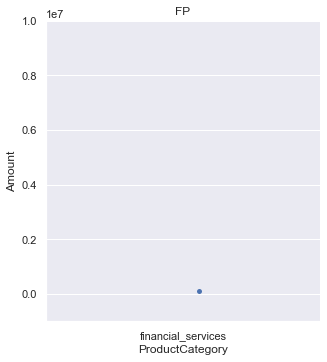

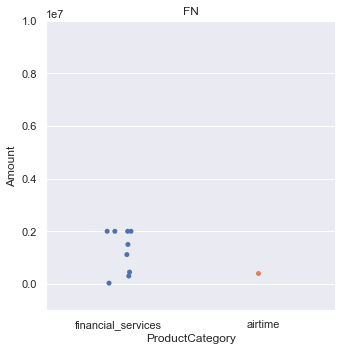

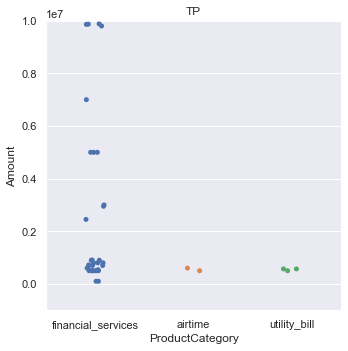

In [27]:
sns.catplot(data= TN, x="ProductCategory",  y="Amount").set(title = "TN", ylim=(-1e6, 1e7))
sns.catplot(data= FP, x="ProductCategory", y="Amount").set(title = "FP", ylim=(-1e6, 1e7))
sns.catplot(data= FN, x="ProductCategory", y="Amount").set(title = "FN", ylim=(-1e6, 1e7))
sns.catplot(data= TP, x="ProductCategory", y="Amount").set(title = "TP", ylim=(-1e6, 1e7))